<a href="https://colab.research.google.com/github/AyozeGS/IABD/blob/main/M2D/T3/M2D_STRIPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problema de Planificación con STRIPS**

El cuaderno está enfocado en aplicar los conceptos de planificación en el contexto de la inteligencia artificial, específicamente utilizando STRIPS (Stanford Research Institute Problem Solver), para resolver un problema de manipulación de bloques en un mundo simulado.

Considera un mundo donde hay cuatro bloques identificados como A, B, C, y D. Existen tres lugares posibles donde ubicarlos, identificados como 1, 2, y 3.

Inicialmente, todos los bloques están apilados en el lugar 1 en el siguiente orden: B encima de A, A encima de C, y C encima de D. El objetivo es llegar a un estado donde los bloques estén apilados en el lugar 3 en el orden, A encima de B, B encima de C, y C encima de D.



\begin{array}{c c c c | c c c c}
&Inicio&&&&&Meta& \\
G &&&&&&& G  \\
  &&&&&&&   \\
B &&&&&&& A \\
A &&&&&&& B \\
C &&&&&&& C \\
D &&&&&&& D \\ \hline
1 & 2 & 3 &&& 1 & 2 & 3
\end{array}



In [2]:
#Hiperparámetros
n_cajas = 4
n_posiciones = 3

# 1. Cálculo de variables y parámetros

NOTA: Volver a ejecutar estas celdas al cambiar los hiperparámetros: n_posicions y n_cajas.


Se calculan algunas variables locales a usar en las diferentes funciones

In [3]:
import string

# Lista con los números de las posiciones. Ej: [1,2,3]
posiciones = list(range(1,n_posiciones+1))

# String con los nombres de las cajas. Ej: "ABCD"
cajas = string.ascii_uppercase[:n_cajas]

# Cálculo del número de operaciones distintas
# Ir     -> (posiciones - ultima_posicion) a derecha + (posiciones - primera_posicion) a izquierda = 2*(posiciones - 1)
# Mover  -> ir llevando una de las cajas = 2*(n_posiciones - 1) x cajas
# Coger  -> cada caja en cada posicion = cajas x posiciones
# Apilar -> cada caja en cada posicion sobre una de las otras cajas o sobre el suelo = cajas x posiciones x (cajas - 1 + suelo'1') = cajas x cajas x posiciones
max_operaciones = 2*(n_posiciones-1) + 2*(n_posiciones-1)*n_cajas + n_posiciones*n_cajas + n_cajas*n_cajas*n_posiciones

# Cálculo de bits de la máscara
# bits para posiciones   -> (cajas + gancho) x posiciones
# bits para apilamientos -> cajas x (cajas-1 + posiciones) x2(S/N)
# bits para libres       -> (cajas + gancho) x2(S/N)
bits_mascara = (n_cajas + 1)*n_posiciones + n_cajas*(n_cajas + n_posiciones - 1)*2 + (n_cajas + 1)*2

# Máscara de unos para eliminar estados
e_mask = 2**(bits_mascara)-1

print(f"Posiciones: {posiciones}")
print(f"Cajas: {cajas}")
print("Nº operaciones máximas: ", max_operaciones)
print("Nº bits máscara: ", bits_mascara)

Posiciones: [1, 2, 3]
Cajas: ABCD
Nº operaciones máximas:  80
Nº bits máscara:  73


Se calculan los diferentes valores que servirán de base para poner a uno cada bit de la máscara binaria y que serán usados en la definición de las máscaras PC, E y A de las operaciones.

In [4]:
# Valores enteros que represetarán el poner a 1 cada uno de los bits de
# la máscara en función del número de cajas y posiciones.
#-------------------------------------------------------------------------------------------
# Cálculo de bases (Ejemplo con 4 cajas y 3 posiciones)
#--------------------------------------------------------------------------------------------
# |    posiciones    |        (cjX/cjY)          |        ~(cjX/cjY)         |  Libre(S/N)  |
#  G   A   B   C   D    A      B      C      D      A      B      C      D    G  A  B  C  D
# 321 321 321 321 321 BCD123 ACD123 ABD123 ABC123 BCD123 ACD123 ABD123 ABC123 SN SN SN SN SN
# 000_000_000_000_000_000000_000000_000000_000000_000000_000000_000000_000000_00_00_00_00_00
#    ^               ^                           ^                           ^              ^
# base(pos_g)  base(pos_cajas)               base(apila)               base(noapila) base(libres)
#-------------------------------------------------------------------------------

# Bases cajas libres / no_libres
base_cajas_no_libres         = 2**0
base_caja_no_libre           = lambda idx_caja : base_cajas_no_libres * 2**((n_cajas-idx_caja-1)*2)
base_caja_libre              = lambda idx_caja : base_caja_no_libre(idx_caja) * 2

# Bases de gancho libre
base_gancho_no_libre         = 2**((n_cajas)*2)
base_gancho_libre            = base_gancho_no_libre * 2

# Bases de cajaX no está sobre cajaY o suelo
base_no_apilamientos         = 2**((n_cajas + 1)*2)
base_no_apilamientos_caja    = lambda idx_caja : base_no_apilamientos * ((2**(n_cajas + n_posiciones - 1))**(n_cajas-idx_caja-1))
aux_indice                   = lambda idx_caja1, idx_caja2: n_cajas + n_posiciones - idx_caja2 - 2 if idx_caja1 > idx_caja2 else n_cajas + n_posiciones - idx_caja2 - 1
base_caja1_no_sobre_caja2    = lambda idx_caja1, idx_caja2 : base_no_apilamientos_caja(idx_caja1) * (2**aux_indice(idx_caja1, idx_caja2))
base_caja_no_sobre_posicion  = lambda idx_caja, posicion : base_no_apilamientos_caja(idx_caja) * (2**(n_posiciones - posicion))

# Bases de cajaX está sobre cajaY o suelo
base_apilamientos            = 2**((n_cajas + 1)*2 + (n_cajas*(n_cajas + n_posiciones - 1)))
base_apilamientos_caja       = lambda idx_caja : base_apilamientos * ((2**(n_cajas + n_posiciones - 1))**(n_cajas-idx_caja-1))
base_caja1_sobre_caja2       = lambda idx_caja1, idx_caja2 : base_apilamientos_caja(idx_caja1) * (2**aux_indice(idx_caja1, idx_caja2))
base_caja_sobre_posicion     = lambda idx_caja, posicion : base_apilamientos_caja(idx_caja) * (2**(n_posiciones - posicion))

# Bases de la posicion de las cajas
base_pos_cajas               = 2**((n_cajas + 1)*2 + (n_cajas*(n_cajas + n_posiciones - 1))*2)
base_pos_caja                = lambda idx_caja : base_pos_cajas * ((2**n_posiciones)**(n_cajas-idx_caja-1))
base_esta_caja_posicion      = lambda idx_caja, posicion : base_pos_caja(idx_caja) * 2**(posicion-1)

# Base de la posición del gancho
base_pos_g                   = 2**((n_cajas + 1)*2 + (n_cajas*(n_cajas + n_posiciones - 1))*2 + n_cajas*n_posiciones)
base_esta_gancho_posicion    = lambda posicion: base_pos_g * 2**(posicion-1)

# 2. Funciones

Este bloque se recogen las distintas funciones para la realización del problema:
- Funciones para convertir vectores en valores binarios y ayudar a visualizarlas.
- Funciones para crear las diferentes operaciones con sus máscaras PC,E y A.
- Funciones de transición de estados y de planificación de STRIPS
- Funciones de visualización de resultados

## 2.1. Propiedades de los estados

Función que convierte un vector de estados iniciales a un valor entero cuya representación binaria respeta la estructura definida anteriormente y que mantiene los estados indicados en el vector.
El valor se va completando desde los bits de mayor orden a los de menor.

In [5]:
# Función que crea una máscara respecto de un vector
def mascara(vector):

  # Se identifican los valores del vector referentes a posiciones
  vector_posiciones = vector[:n_cajas+1]
  # Se identifican los valores del vector referentes a apilamientos de cajas
  vector_apilamientos = vector[n_cajas+1:]

  # Se enmascara la Posición de G
  mascara = 2**(vector_posiciones[0]-1) #Posición de G
  #print(f"Enmascarada posición de G")

  # Se enmascara la posición de las cajas
  for idx, caja in enumerate(cajas):
    mascara *= 2**(n_posiciones)
    mascara += 2**(vector_posiciones[idx+1]-1) #Posición de cada caja
    #print(f"Enmascarada posición de {caja}")

  # Se enmascaran que cajas están encima de otras y sobre las posiciones a
  # la vez que se almacenan los valores negados en una máscara auxiliar
  mascara_no_apilamientos = []
  for idx_caja, caja_superior in enumerate(cajas):
    flag_caja_esta_sobre_otra = False

    # Se enmascara sobre que otra caja está cada caja
    for caja_inferior in cajas.replace(caja_superior, ""):
      mascara *= 2
      if caja_superior+caja_inferior in vector_apilamientos:
        mascara += 1
        mascara_no_apilamientos.append(0)
        flag_caja_esta_sobre_otra = True
      else:
        mascara_no_apilamientos.append(1)

    # Se enmascara en que posición está la caja si está en el suelo
    for posicion in posiciones:
      mascara *= 2
      if not flag_caja_esta_sobre_otra and vector_posiciones[idx_caja+1] == posicion:
        mascara +=1
        mascara_no_apilamientos.append(0)
      else:
        mascara_no_apilamientos.append(1)

  # Se enmascaran que cajas no están encima de otras o sobre el suelo usando
  # la máscara auxiliar de valores negados
  for bit in mascara_no_apilamientos:
    mascara *= 2
    mascara += bit

  # Se enmascara que el gancho y las cajas están libres #10(G)-10(A)-10(B)-10(C)-...
  for i in range(n_cajas+1):
    mascara *= 4
    mascara += 2

  return mascara

Función que permite visualizar el estado en formato de máscara, separando los disntitos bloques que se han definido en ella.

In [6]:
# Función que permite visualizar la máscara de manera agradable
def mostrar(valor):

  # Si el valor es un entero se pasa a cadena binaria.
  if isinstance(valor, int):
    valor = bin(valor)

  # Se quita el 0b del inicio de la cadena y se añaden los 0s faltantes al principio
  mascara = valor[2:].zfill(bits_mascara)

  # Se separa la máscara por grupos
  mascara_posiciones = mascara[:(1+n_cajas)*n_posiciones]
  mascara_apilamientos = mascara[(1+n_cajas)*n_posiciones:-(1+n_cajas)*2]
  mascara_libres = mascara[-(1+n_cajas)*2:]

  # Se añaden guiones para separar subgrupos
  mascara_posiciones = '_'.join([mascara_posiciones[i:i+n_posiciones] for i in range(0, len(mascara_posiciones), n_posiciones)])
  mascara_apilamientos = '_'.join([mascara_apilamientos[i:i+n_cajas+n_posiciones-1] for i in range(0, len(mascara_apilamientos), n_cajas+n_posiciones-1)])
  mascara_libres = '_'.join([mascara_libres[i:i+2] for i in range(0, len(mascara_libres), 2)])

  # Se añaden guiones para separar grupos
  mascara = "_".join([mascara_posiciones, mascara_apilamientos, mascara_libres])
  return mascara

#Ejemplo del uso de las funciones anteriores para 4 cajas y 3 posiciones
vector_inicial_ejemplo = [1, 1, 1, 1, 1, 'BA', 'AC', 'CD']
vector_meta_ejemplo=[3, 3, 3, 3, 3, 'AB', 'BC', 'CD']

print("VECTOR INICIAL:", vector_inicial_ejemplo)
print("\n____posiciones________________sobre______________________no_sobre____________libres_s/n___")
print("_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_")
print(mostrar(mascara(vector_inicial_ejemplo)))

print("\nVECTOR META:", vector_meta_ejemplo)
print("\n____posiciones________________sobre______________________no_sobre____________libres_s/n___")
print("_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_")
print(mostrar(mascara(vector_meta_ejemplo)))

VECTOR INICIAL: [1, 1, 1, 1, 1, 'BA', 'AC', 'CD']

____posiciones________________sobre______________________no_sobre____________libres_s/n___
_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_
001_001_001_001_001_010000_100000_001000_000100_101111_011111_110111_111011_10_10_10_10_10

VECTOR META: [3, 3, 3, 3, 3, 'AB', 'BC', 'CD']

____posiciones________________sobre______________________no_sobre____________libres_s/n___
_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_
100_100_100_100_100_100000_010000_001000_000001_011111_101111_110111_111110_10_10_10_10_10


## 2.2. Operadores STRIPS

Funciones que definen 4 tipos de operaciones principales:
- Ir: desplaza el gancho libre entre posiciones.
- Mover: desplaza el gancho y una caja entre posiciones.
- Coger: quita una caja del elemento sobre el que estuviera y ocupa ambos caja y gancho.
- Apilar: coloca una caja sobre un elemento y libera la caja y el gancho.

Cada operador o acción se define por medio de un nombre y de las siguientes atributos:
- PC: Precondiciones que indican las propiedades que deben cumplirse para que la acción pueda realizarse.
- E: Máscara que indica las propiedades que deben eliminarse para cambiar de estado.
- A: Máscara que indica las propiedades que deben añadirse para cambiar de estado.

### 2.2.1. Operaciones tipo IR

In [7]:
# Funcion que crea operadores strips del tipo ir
def definir_acciones_ir():

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones en ambos sentidos entre cada posición y la siguiente
  for posicion in posiciones[:-1]:

#-------------------------------------------------------------------------------
    acciones.append(f"Ir(G,{posicion},{posicion+1})")
    #PC -> Está(G,posicion), Libre(G)
    PC.append(base_esta_gancho_posicion(posicion) + base_gancho_libre)
    #E -> Está(G,posicion)
    E.append(e_mask - base_esta_gancho_posicion(posicion))
    #A -> Está (G,posicion+1)
    A.append(base_esta_gancho_posicion(posicion+1))
#-------------------------------------------------------------------------------
    acciones.append(f"Ir(G,{posicion+1},{posicion})")
    #PC -> Está(G,posicion+1), Libre(G)
    PC.append(base_esta_gancho_posicion(posicion+1) + base_gancho_libre)
    #E -> Está(G,posicion+1)
    E.append(e_mask - base_esta_gancho_posicion(posicion+1))
    #A -> Está (G,posicion)
    A.append(base_esta_gancho_posicion(posicion))
#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Código para mostrar las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_ir(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### 2.2.2. Operaciones tipo MOVER

In [8]:
# Funcion que crea operadores strips del tipo mover
def definir_acciones_mover():

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones para cada caja
  for idx_caja, caja in enumerate(cajas):
    # Definimos operaciones en ambos sentidos entre cada posición y la siguiente
    for posicion in posiciones[:-1]:

#-------------------------------------------------------------------------------
      acciones.append(f"Mover(G,{caja},{posicion},{posicion+1})")
      #PC -> Está(G,posicion), Está(caja,posicion), NoLibre(G), NoLibre(caja)
      PC.append(base_esta_gancho_posicion(posicion) +
                base_esta_caja_posicion(idx_caja, posicion) +
                base_gancho_no_libre +
                base_caja_no_libre(idx_caja))
      #E -> Está(G,posicion), Está(caja,posicion)
      E.append(e_mask - base_esta_gancho_posicion(posicion) -
               base_esta_caja_posicion(idx_caja, posicion))
      #A -> Está(G,posicion+1), Está(caja,posicion+1)
      A.append(base_esta_gancho_posicion(posicion+1) +
               base_esta_caja_posicion(idx_caja, posicion+1))
#-------------------------------------------------------------------------------
      acciones.append(f"Mover(G,{caja},{posicion+1},{posicion})")
      #PC -> Está(G,posicion+1), Está(caja,posicion+1), NoLibre(G), NoLibre(caja)
      PC.append(base_esta_gancho_posicion(posicion+1) +
                base_esta_caja_posicion(idx_caja, posicion+1) +
                base_gancho_no_libre +
                base_caja_no_libre(idx_caja))
      #E -> Está(G,posicion+1), Está(caja,posicion+1)
      E.append(e_mask - base_esta_gancho_posicion(posicion+1) -
               base_esta_caja_posicion(idx_caja, posicion+1))
      #A -> Está(G,posicion), Está(caja,posicion)
      A.append(base_esta_gancho_posicion(posicion) +
               base_esta_caja_posicion(idx_caja, posicion))
#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Muestra las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_mover(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### 2.2.3. Operaciones tipo  COGER

In [9]:
# Funcion que crea operadores strips del tipo coger
def definir_acciones_coger():

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones para cada caja
  for idx_caja, caja in enumerate(cajas):
    # Definimos operaciones para cada posicion
    for posicion in posiciones:

#-------------------------------------------------------------------------------
      acciones.append(f"Coger(G,{caja},{posicion})")
      #PC -> Está(G,posicion), Esta(caja,posicion), Libre(G), Libre(caja), NoSobre(Otrascajas*, caja)
      pc = base_esta_gancho_posicion(posicion) + base_esta_caja_posicion(idx_caja, posicion) + base_gancho_libre + base_caja_libre(idx_caja)
      #Se comprueba que la caja no está debajo de ninguna otra
      for idx_superior, caja_superior in enumerate(cajas):
        if (idx_caja == idx_superior):
          continue
        pc += base_caja1_no_sobre_caja2(idx_superior, idx_caja)
      PC.append(pc)
      #E -> Libre(G), Libre(caja), Sobre(caja, Otrascajas*)
      e = base_gancho_libre + base_caja_libre(idx_caja)
      # Eliminar los estados de la caja sobre las otras cajas y las posiciones
      for idx_inferior in range(n_cajas+n_posiciones-1):
        e += base_apilamientos_caja(idx_caja) * (2**idx_inferior)
      E.append(e_mask - e)
      #A -> NoLibre(G), NoLibre(caja), NoSobre (caja, Otrascajas*)
      a = base_gancho_no_libre + base_caja_no_libre(idx_caja)
      # Añade los estados de la caja no sobre las otras cajas ni el suelo
      for idx_inferior in range(n_cajas+n_posiciones-1):
        a += base_no_apilamientos_caja(idx_caja) * (2**idx_inferior)
      A.append(a)
#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Muestra las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_coger(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### 2.2.4. Operaciones tipo APILAR

In [10]:
# Funcion que crea operadores strips del tipo apilar
def definir_acciones_apilar():

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones para cada caja
  for idx_caja, caja in enumerate(cajas):
    # Definimos operaciones para cada posicion
    for posicion in posiciones:
      # Definimos operaciones para las otras cajas
      for idx_inferior, caja_inferior in enumerate(cajas):
        if (idx_caja == idx_inferior):
            continue

#-------------------------------------------------------------------------------
        acciones.append(f"Apilar(G,{caja},{caja_inferior},{posicion})")
        #PC -> Está(G,posicion), Está(caja,posicion), Está(caja_inferior,posicion), NoLibre(G), NoLibre(caja), NoSobre(Otrascajas*, caja_inferior)
        pc_aux = 0
        #Se comprueba que la caja sobre la que se va a colocar no está debajo de ninguna otra
        for idx_superior, caja_superior in enumerate(cajas):
          if (idx_inferior == idx_superior):
            continue
          pc_aux += base_caja1_no_sobre_caja2(idx_superior, idx_inferior)
        PC.append(base_esta_gancho_posicion(posicion) + base_esta_caja_posicion(idx_caja, posicion) +
                  base_esta_caja_posicion(idx_inferior, posicion) + base_gancho_no_libre +
                  base_caja_no_libre(idx_caja) + pc_aux)
        #E -> NoLibre(G), NoLibre(caja), Nosobre(caja, caja_inferior)
        E.append(e_mask - base_gancho_no_libre - base_caja_no_libre(idx_caja) - base_caja1_no_sobre_caja2(idx_caja, idx_inferior))
        #A -> Libre(G), Libre(caja), Sobre(caja, caja_inferior)
        A.append(base_gancho_libre + base_caja_libre(idx_caja) + base_caja1_sobre_caja2(idx_caja, idx_inferior))
#-------------------------------------------------------------------------------
      acciones.append(f"Apilar(G,{caja},{posicion})")
      #PC -> Está(G,posicion), Está(caja,posicion), NoLibre(G), NoLibre(caja), NoSobre(cajas*, posicion)
      pc_aux = 0
      #Se comprueba que noy cajas sobre esa posición donde se va a colocar la caja
      for idx_superior, caja_superior in enumerate(cajas):
        pc_aux += base_caja_no_sobre_posicion(idx_superior, posicion)
      PC.append(base_esta_gancho_posicion(posicion) + base_esta_caja_posicion(idx_caja, posicion) +
                base_gancho_no_libre + base_caja_no_libre(idx_caja) + pc_aux)
      #E -> NoLibre(G), NoLibre(caja), NoSobre(caja, posicion)
      E.append(e_mask - base_gancho_no_libre - base_caja_no_libre(idx_caja) - base_caja_no_sobre_posicion(idx_caja, posicion))
      #A -> Libre(G), Libre(caja), Sobre(caja, posicion)
      A.append(base_gancho_libre + base_caja_libre(idx_caja) + base_caja_sobre_posicion(idx_caja, posicion))
#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Muestra las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_apilar(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### 2.2.5. Concatenación de operaciones

Función que unifica las acciones definidas para cada tipo y crea vectores conteniendo las máscaras de todas las operaciones definidas para el problema.

NOTA: Debe volver a llamarse cuando se modifiquen los hiperparámetros de n_cajas y n_posiciones.

In [11]:
#------------------------------------------------------------------------------
# CONCATENACION DE OPERACIONES
#------------------------------------------------------------------------------
def definir_acciones():

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []
  # Generamos las acciones de cada tipo
  acciones_ir, PC_ir, E_ir, A_ir = definir_acciones_ir()
  acciones_coger, PC_coger, E_coger, A_coger = definir_acciones_coger()
  acciones_mover, PC_mover, E_mover, A_mover = definir_acciones_mover()
  acciones_apilar, PC_apilar, E_apilar, A_apilar = definir_acciones_apilar()
  # Concatenamos las acciones y sus máscaras
  acciones += acciones_coger + acciones_mover + acciones_apilar + acciones_ir
  PC += PC_coger + PC_mover + PC_apilar + PC_ir
  E = E_coger + E_mover + E_apilar + E_ir
  A += A_coger + A_mover + A_apilar + A_ir
  return acciones, PC, E, A

#Ejemplo de visualizar el resultado de las operaciones
texto, PC, E, A = definir_acciones()
for i in range(len(texto)):
  print(f"[{i}] {texto[i]}")
  print("PC:", mostrar(PC[i]))
  print("E: ", mostrar(E[i]))
  print("A: ", mostrar(A[i]))

[0] Coger(G,A,1)
PC: 001_001_000_000_000_000000_000000_000000_000000_000000_100000_100000_100000_10_10_00_00_00
E:  111_111_111_111_111_000000_111111_111111_111111_111111_111111_111111_111111_01_01_11_11_11
A:  000_000_000_000_000_000000_000000_000000_000000_111111_000000_000000_000000_01_01_00_00_00
[1] Coger(G,A,2)
PC: 010_010_000_000_000_000000_000000_000000_000000_000000_100000_100000_100000_10_10_00_00_00
E:  111_111_111_111_111_000000_111111_111111_111111_111111_111111_111111_111111_01_01_11_11_11
A:  000_000_000_000_000_000000_000000_000000_000000_111111_000000_000000_000000_01_01_00_00_00
[2] Coger(G,A,3)
PC: 100_100_000_000_000_000000_000000_000000_000000_000000_100000_100000_100000_10_10_00_00_00
E:  111_111_111_111_111_000000_111111_111111_111111_111111_111111_111111_111111_01_01_11_11_11
A:  000_000_000_000_000_000000_000000_000000_000000_111111_000000_000000_000000_01_01_00_00_00
[3] Coger(G,B,1)
PC: 001_000_001_000_000_000000_000000_000000_000000_100000_000000_010000_0100

## 2.3. Algoritmos de Planificación y Transición

### 2.3.1. Función de transición

Función de transición que actualiza el estado del mundo después de realizar una acción utilizando las máscaras que comprueban, eliminan y añaden atributos.

In [12]:
#Función de transición
def intentar(nodo,op, info_mostrada=False):

  if info_mostrada:
    print("\nIntentar operación", f"{op}", texto[op])
    print("Precondiciones ->", mostrar(PC[op]))
    print("Estado Actual  ->", mostrar(nodo))

  #Se comprueba que se cumplan las precondiciones
  if (bin(nodo & PC[op]) == bin(PC[op])):

    # Se eliminan los estados indicados por E
    siguiente=int(bin(nodo & E[op]),2)
    # Se añaden los estados indicados por A
    siguiente=int(bin(siguiente | A[op]),2)

    if info_mostrada:
      print("Se eliminan E  ->", mostrar(E[op]))
      print("Se añaden A    ->", mostrar(A[op]))
      print("Est. Siguiente ->", mostrar(siguiente))

  else:
    if info_mostrada:
      print("No se cumplen las precondiciones")
    siguiente=-1

  return siguiente

### 2.3.2. Función de planificación

Función que utiliza STRIPS para planificar una secuencia de acciones que conduce del estado inicial al estado objetivo y mediante un algoritmo de exploración en profundidad no recursivo. Contiene una función interna para comprobar si un estado al que se quiere pasar ya se ha guardado en la pila.

In [13]:
def resolver(inicial, meta, max_profundidad, info_acciones=False, info_pila=False, info_transicion=False):

  #Función de comprobación en la pila del estado consecuencia de realizar una acción
  def encontrado(info_mostrada=False):
    encontrado=False
    if info_mostrada:
      print("Comprobando estado alcanzado por operación", texto[indice_operacion])
    #Se recorre la pila hacia atrás buscando ya se ha guardado el estado actual
    for t in range(indice_pila+1):
        if (estados[t] == estado_siguiente):
          encontrado=True
          if info_mostrada:
            print("Estado repetido en posicion", t)
    if info_mostrada and not encontrado:
      print("No se ha encontrado coincidencias en la pila de estados")
    return encontrado

  indice_pila = 0 # Cima de la pila
  indice_operacion = 0 # Índice de operación
  estado_actual = inicial # Estado actual
  # Pila de estados
  estados = [0]*max_profundidad
  estados[indice_pila] = 0
  # Pila de operaciones
  operaciones = [0]*max_profundidad
  operaciones[indice_pila] = 0

  # Mientras queden estados por explorar
  while (indice_pila>=0):

    if info_pila:
      print("\nRetorno a operación:", texto[operaciones[indice_pila]] if indice_pila > 0 else "INICIO")

    while ((indice_operacion < max_operaciones) and (indice_pila < max_profundidad-1) and (estado_actual != meta)):

        # Intenta realizar la acción op sobre el estado actual
        estado_siguiente = intentar(estado_actual, indice_operacion, info_transicion)

        # Si se han cumplido las precondiciones se procesa el nuevo estado.
        if (estado_siguiente!=-1): # -1 es null acción no permitida

          # Si el estado no está en la pila se guarda y se avanza a la siguiente posición
          if (not(encontrado(info_pila))):

            # Mantenemos en la pila el estado y la acción incrementando el índice en 1
            indice_pila += 1
            estados[indice_pila] = estado_actual
            operaciones[indice_pila] = indice_operacion
            # Saltamos al siguiente estado
            estado_actual = estado_siguiente
            indice_operacion = -1 # Para que empiece en 0

            #Si se encuentra el estado final se devuelve la pila de operaciones
            if (int(bin(estado_actual & meta),2)==int(bin(meta),2)):
              if info_acciones:
                print("\n------------------------------------------------------------------------------------------------------------------\n")
              return operaciones[1:indice_pila+1]

            # Muestra información de la pila de operaciones
            if info_acciones:
              if info_transicion or info_pila:
                print("\n------------------------------------------------------------------------------------------------------------------\n")
              print("INICIO-->", end="")
              for t in range(1,indice_pila+1):
                print(f"{texto[operaciones[t]]}-->",end='')
              print("FIN")

        indice_operacion += 1

    # Si se han probado todas las operaciones para un estado se retrocede al anterior
    estado_actual = estados[indice_pila]
    # Se continuan las operaciones en la siguiente a la que se había utilizado para avanzar
    indice_operacion = operaciones[indice_pila]+1
    indice_pila -= 1

  return []

## 2.4. Visualización

Funciones de visualización en forma de texto y grafo

In [14]:
# Resultado de la pila de acciones en texto
def mostrar_solucion_texto(operaciones):
  print("SOLUCIÓN:")
  if operaciones:
    print("INICIO-->", end="")
    for t in range(len(operaciones)):
      print(f"{texto[operaciones[t]]}-->",end='\n' if t%5 == 4 else "")
    print("FIN")
  else:
    print("No se ha encontrado una solución")

Función que dibuja un grafo con la sucesión de pasos encontrada en la solución

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt, ceil

# Resultado de la pila de acciones en grafo
def mostrar_solucion_grafo(operaciones):

  if operaciones:
    # Creamos las etiquetas de los nodos
    nodos = [texto[i] for i in operaciones]
    nodos = [str(i+1) + ". " + nodos[i] for i in range(len(nodos))]
    nodos.insert(0, "INICIO")
    nodos.append("FIN")

    # Definimos las aristas (y nodos) del grafo
    edges = [("INICIO", nodos[0])]
    for i in range(len(operaciones)):
      edges.append((nodos[i], nodos[i+1]))
    edges.append((nodos[len(operaciones)], "FIN"))

    # Difinimos el grafo de acciones y y añadimos las aristas y nodos al grafo
    grafo_acciones = nx.DiGraph()
    grafo_acciones.add_edges_from(edges)

    # Se definen las posiciones de los nodos en filas y columnas
    dim = ceil(sqrt(len(nodos)))
    col = lambda x: x%dim
    row = lambda x: x//dim
    posiciones_nodos = {nodo: (col(i) if row(i)%2 == 0 else dim-col(i)-1, row(i)) for i, nodo in enumerate(nodos)}

    # Visualizamos el grafo de acciones
    nx.draw(grafo_acciones, pos=posiciones_nodos, with_labels=True, node_size=3000, node_color="skyblue", font_size=5, font_color="black", font_weight="bold", arrowsize=20)
    plt.show()

  else:
    print("No se ha encontrado una solución")

# 3. Ejecución

In [16]:
# Parámetros
vector_inicial = [1, 1, 1, 1, 1, 'BA', 'AC', 'CD']
vector_meta = [3, 3, 3, 3, 3, 'AB', 'BC', 'CD']
max_profundidad=36

# Se llama a la función para generar las operaciones y se guarda su información
texto, PC, E, A = definir_acciones()
# Ejecución de la función de planificación
operaciones = resolver(mascara(vector_inicial), mascara(vector_meta), max_profundidad, False, False, False)
#Se muestra la solución
mostrar_solucion_texto(operaciones)

SOLUCIÓN:
INICIO-->Coger(G,B,1)-->Mover(G,B,1,2)-->Mover(G,B,2,3)-->Apilar(G,B,3)-->Ir(G,3,2)-->
Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->Apilar(G,A,2)-->Ir(G,2,3)-->
Coger(G,B,3)-->Mover(G,B,3,2)-->Apilar(G,B,A,2)-->Ir(G,2,1)-->Coger(G,C,1)-->
Mover(G,C,1,2)-->Apilar(G,C,B,2)-->Ir(G,2,1)-->Coger(G,D,1)-->Mover(G,D,1,2)-->
Mover(G,D,2,3)-->Apilar(G,D,3)-->Ir(G,3,2)-->Coger(G,C,2)-->Mover(G,C,2,3)-->
Apilar(G,C,D,3)-->Ir(G,3,2)-->Coger(G,B,2)-->Mover(G,B,2,3)-->Apilar(G,B,C,3)-->
Ir(G,3,2)-->Coger(G,A,2)-->Mover(G,A,2,3)-->Apilar(G,A,B,3)-->FIN


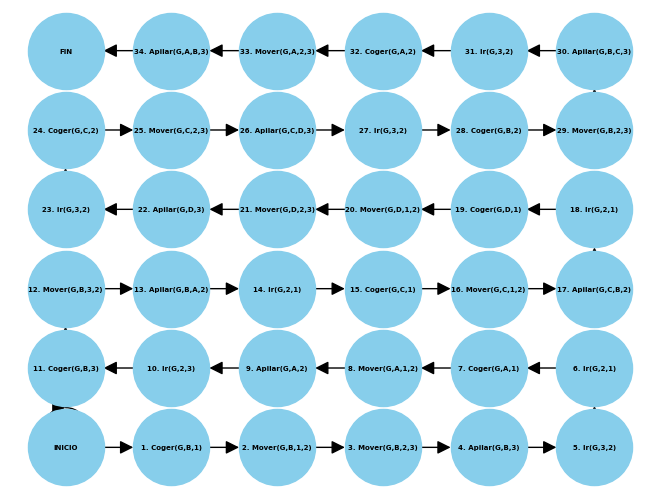

In [17]:
mostrar_solucion_grafo(operaciones)

# 4. Extras

### 4.1. Ejemplo de algoritmo de comprobación de solución

Algoritmo que permite introducir manualmente una secuencia de operaciones y comprobar si el estado final esperado es alcanzado. Cambiendo el tercer parámetro de la función intentar a True podemos ver las máscaras PC,E y A correspondientes a cada operación y saber que operación no ha podido realizarse.

In [96]:
# Función que realiza las transciones de estado para una secuencia de pasos y comprueba
# si el estado alcanzado coincide con el esperado
def comprobar_solucion(vector_inicial, vector_final, acciones_prueba, info_mostrada):

  estado_actual = mascara(vector_inicial)
  estado_final = mascara(vector_final)

  # Si la secuencia de acciones es un cadena se eliminan los estados de INICIO y FIN
  # y se transforman los pasos a formato lista
  if isinstance(acciones_prueba, str):
    if acciones_prueba.startswith("INICIO-->"):
      acciones_prueba = acciones_prueba[9:]
    if acciones_prueba.endswith("-->FIN"):
      acciones_prueba = acciones_prueba[:-6]
    acciones_prueba = acciones_prueba.split("-->")

  for accion_prueba in acciones_prueba:
    indice = texto.index(accion_prueba)
    estado_siguiente = intentar(estado_actual, indice, info_mostrada)
    if estado_siguiente != -1:
      estado_actual = estado_siguiente

  print("\nSolución válida" if estado_final == estado_actual else "\nSolución no válida")
  print("Esperado: ", mostrar(estado_final))
  print("Calculado:", mostrar(estado_actual))


#Máscaras para 4 cajas y 3 posiciones
vector_inicial = [1, 1, 1, 1, 1, 'BA', 'AC', 'CD']
vector_meta= [3, 3, 3, 3, 3, 'AB', 'BC', 'CD']

acciones_prueba = "INICIO-->Mover(G,B,1,2)-->Coger(G,B,1)-->FIN"

# Acciones en formato cadena
#acciones_prueba = "Coger(G,B,1)-->Mover(G,B,1,2)-->Apilar(G,B,2)-->Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->Apilar(G,A,B,2)-->Ir(G,2,1)-->Coger(G,C,1)-->" + \
#                  "Mover(G,C,1,2)-->Apilar(G,C,A,2)-->Ir(G,2,1)-->Coger(G,D,1)-->Mover(G,D,1,2)-->Mover(G,D,2,3)-->Apilar(G,D,3)-->Ir(G,3,2)-->Coger(G,C,2)-->" + \
#                  "Mover(G,C,2,3)-->Apilar(G,C,D,3)-->Ir(G,3,2)-->Coger(G,A,2)-->Mover(G,A,2,1)-->Apilar(G,A,1)-->Ir(G,1,2)-->Coger(G,B,2)-->Mover(G,B,2,3)-->" + \
#                  "Apilar(G,B,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->Mover(G,A,2,3)-->Apilar(G,A,B,3)"

# Acciones en formato lista
#acciones_prueba = [
#    "Coger(G,B,1)", "Mover(G,B,1,2)", "Apilar(G,B,2)", "Ir(G,2,1)", "Coger(G,A,1)", "Mover(G,A,1,2)", "Apilar(G,A,B,2)", "Ir(G,2,1)",
#    "Coger(G,C,1)", "Mover(G,C,1,2)", "Apilar(G,C,A,2)", "Ir(G,2,1)", "Coger(G,D,1)", "Mover(G,D,1,2)", "Mover(G,D,2,3)", "Apilar(G,D,3)",
#    "Ir(G,3,2)", "Coger(G,C,2)", "Mover(G,C,2,3)", "Apilar(G,C,D,3)", "Ir(G,3,2)", "Coger(G,A,2)", "Mover(G,A,2,1)", "Apilar(G,A,1)",
#    "Ir(G,1,2)", "Coger(G,B,2)", "Mover(G,B,2,3)", "Apilar(G,B,C,3)",
#    "Ir(G,3,2)", "Ir(G,2,1)", "Coger(G,A,1)", "Mover(G,A,1,2)",
#    "Mover(G,A,2,3)", "Apilar(G,A,B,3)"
#    ]

comprobar_solucion(vector_inicial, vector_meta, acciones_prueba, True)


Intentar operación 16 Mover(G,B,1,2)
Precondiciones -> 001_000_001_000_000_000000_000000_000000_000000_000000_000000_000000_000000_01_00_01_00_00
Estado Actual  -> 001_001_001_001_001_010000_100000_001000_000100_101111_011111_110111_111011_10_10_10_10_10
No se cumplen las precondiciones

Intentar operación 3 Coger(G,B,1)
Precondiciones -> 001_000_001_000_000_000000_000000_000000_000000_100000_000000_010000_010000_10_00_10_00_00
Estado Actual  -> 001_001_001_001_001_010000_100000_001000_000100_101111_011111_110111_111011_10_10_10_10_10
Se eliminan E  -> 111_111_111_111_111_111111_000000_111111_111111_111111_111111_111111_111111_01_11_01_11_11
Se añaden A    -> 000_000_000_000_000_000000_000000_000000_000000_000000_111111_000000_000000_01_00_01_00_00
Est. Siguiente -> 001_001_001_001_001_010000_000000_001000_000100_101111_111111_110111_111011_01_10_01_10_10

Solución no válida
Esperado:  100_100_100_100_100_100000_010000_001000_000001_011111_101111_110111_111110_10_10_10_10_10
Calculado

### 4.2. Ejemplo Solucion en Texto para 7 cajas y 5 posiciones

In [168]:
import time
inicio_tiempo = time.time()

# Ejemplo con 7 cajas y 5 posiciones
vector_inicial = [1, 1, 1, 1, 1, 5, 5, 5, 'BA', 'CB', 'DC', 'EF', 'FG']
vector_meta = [3, 1, 2, 3, 4, 5, 2, 4, 'FB', 'GD']
max_profundidad = 45
# NOTA: Cambiar hiperparámetros y recalcular variables del inicio del cuaderno
texto, PC, E, A = definir_acciones()
operaciones = resolver(mascara(vector_inicial), mascara(vector_meta), max_profundidad, False, False, False)
mostrar_solucion_texto(operaciones)

# Calculamos el tiempo que se tarda en mostrar la solución
fin_tiempo = time.time()
tiempo_ejecucion = fin_tiempo - inicio_tiempo
print(f"\nTiempo de ejecución: {tiempo_ejecucion} segundos")

SOLUCIÓN:
INICIO-->Coger(G,D,1)-->Mover(G,D,1,2)-->Mover(G,D,2,3)-->Mover(G,D,3,4)-->Apilar(G,D,4)-->
Ir(G,4,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,C,1)-->Mover(G,C,1,2)-->
Mover(G,C,2,3)-->Apilar(G,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,B,1)-->
Mover(G,B,1,2)-->Apilar(G,B,2)-->Ir(G,2,3)-->Ir(G,3,4)-->Ir(G,4,5)-->
Coger(G,E,5)-->Mover(G,E,5,4)-->Mover(G,E,4,3)-->Apilar(G,E,C,3)-->Ir(G,3,4)-->
Ir(G,4,5)-->Coger(G,F,5)-->Mover(G,F,5,4)-->Mover(G,F,4,3)-->Mover(G,F,3,2)-->
Apilar(G,F,B,2)-->Ir(G,2,3)-->Ir(G,3,4)-->Ir(G,4,5)-->Coger(G,G,5)-->
Mover(G,G,5,4)-->Apilar(G,G,D,4)-->Ir(G,4,3)-->Coger(G,E,3)-->Mover(G,E,3,4)-->
Mover(G,E,4,5)-->Apilar(G,E,5)-->Ir(G,5,4)-->Ir(G,4,3)-->FIN

Tiempo de ejecución: 892.9831438064575 segundos


### 4.3. Ejemplo de solución no encontrada en texto con 2 cajas y 2 posiciones con información de pila más detallada

In [148]:
#Ejemplo con 2 cajas y 2 posiciones
vector_inicial = [1, 1, 1,'AB']
vector_meta = [2, 1, 2]
max_profundidad = 4
#NOTA: Cambiar hiperparámetros y recalcular variables del inicio del cuaderno
texto, PC, E, A = definir_acciones()
operaciones = resolver(mascara(vector_inicial), mascara(vector_meta), max_profundidad, True, True, False)
mostrar_solucion_texto(operaciones)


Retorno a operación: INICIO
Comprobando estado alcanzado por operación Coger(G,A,1)
No se ha encontrado coincidencias en la pila de estados

------------------------------------------------------------------------------------------------------------------

INICIO-->Coger(G,A,1)-->FIN
Comprobando estado alcanzado por operación Mover(G,A,1,2)
No se ha encontrado coincidencias en la pila de estados

------------------------------------------------------------------------------------------------------------------

INICIO-->Coger(G,A,1)-->Mover(G,A,1,2)-->FIN
Comprobando estado alcanzado por operación Mover(G,A,2,1)
Estado repetido en posicion 2
Comprobando estado alcanzado por operación Apilar(G,A,2)
No se ha encontrado coincidencias en la pila de estados

------------------------------------------------------------------------------------------------------------------

INICIO-->Coger(G,A,1)-->Mover(G,A,1,2)-->Apilar(G,A,2)-->FIN

Retorno a operación: Mover(G,A,1,2)

Retorno a operación: 

### 4.4. Ejemplo de solución gráfica con 3 cajas y 3 posiciones con información de pila previa básica

INICIO-->Coger(G,C,1)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->Apilar(G,C,3)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->Apilar(G,C,3)-->Ir(G,3,2)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->Apilar(G,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->Apilar(G,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,A,1)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->Apilar(G,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->Apilar(G,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->Mover(G,A,2,3)-->FIN
INICIO-->Coger(G,C,1)-->Mover(G,C,1,2)-->Mover(G,C,2,3)-->Apilar(G,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->Mover(G,A,2,3)-->Apilar(G,A,C,3)-->FIN
INICIO-->Coger(G,C,1)-->

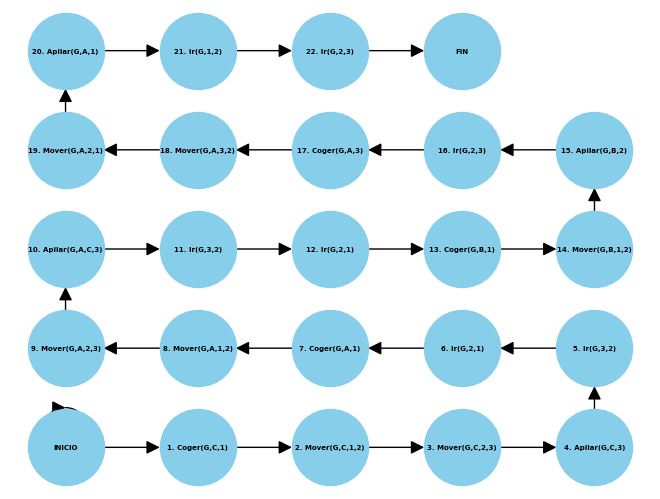

In [152]:
#Ejemplo con 3 cajas y 3 posiciones
vector_inicial = [1, 1, 1, 1, 'AB', 'CA']
vector_meta = [3, 1, 2, 3]
max_profundidad = 25
#NOTA: Cambiar hiperparámetros y recalcular variables del inicio del cuaderno
texto, PC, E, A = definir_acciones()
operaciones = resolver(mascara(vector_inicial), mascara(vector_meta), max_profundidad, True, False, False)
mostrar_solucion_grafo(operaciones)